<a href="https://colab.research.google.com/github/anu04596/DeepLearningTuotorial/blob/main/Day17(Grad_Cam).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Grad Cam using ReseNet18


Import Libraries

In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

Load Pretrained ResNet18 model

In [2]:
model=models.resnet18(pretrained=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Hook to capture gradients and activations

In [3]:
gradients=[]
activations=[]
def save_gradient(model,grad_input,grad_output):
  gradients.append(grad_output[0])
def save_activation(model,input,output):
  activations.append(output)

In [4]:
target_layer=model.layer4[1].conv2
target_layer.register_forward_hook(save_activation)
target_layer.register_backward_hook(save_gradient)

Image Preprocessing

In [5]:
imag_path='/content/cat.jpg'
image=Image.open(imag_path).convert('RGB')

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)


Forward Pass and Predicted Class

In [7]:
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Backward Pass

In [8]:
model.zero_grad()
class_score = output[0, pred_class]
class_score.backward()


Generate Heatmap

In [10]:
grads_val = gradients[0].detach()
acts_val = activations[0].detach()
weights = grads_val.mean(dim=(2, 3), keepdim=True)


In [11]:
grad_cam_map = F.relu((weights * acts_val).sum(dim=1, keepdim=True))
grad_cam_map = F.interpolate(grad_cam_map, size=(224, 224), mode='bilinear', align_corners=False)
grad_cam_map = grad_cam_map.squeeze().cpu().numpy()


In [12]:
grad_cam_map -= grad_cam_map.min()
grad_cam_map /= grad_cam_map.max()


In [13]:
original_img = cv2.cvtColor(np.array(image.resize((224, 224))), cv2.COLOR_RGB2BGR)
heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(original_img, 0.5, heatmap, 0.5, 0)


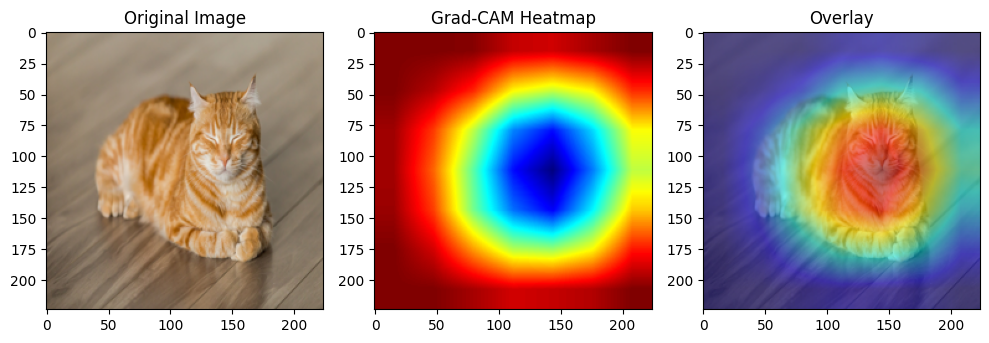

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_img[:, :, ::-1])
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(overlay[:, :, ::-1])
plt.title("Overlay")
plt.tight_layout()
plt.show()
